## 0. Importing libraries and set up device agnostic code

In [1]:
# Import libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets

In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [3]:
import requests
import zipfile
from pathlib import Path


# setup data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists.")
else:
  print(f"{image_path} does not exist, creating one....")
  image_path.mkdir(parents=True, exist_ok = True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downlaoding pizza sushi and steak data...")
  f.write(request.content)

# Unzip the data zip folder
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping the pizza steak and sushi data")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one....
Downlaoding pizza sushi and steak data...
Unziping the pizza steak and sushi data


## 2. Becoming one with data

In [4]:
import os

def walk_through_data(dir_path):
  """Walk through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [5]:
walk_through_data(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [6]:
# Setup training and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Random image path: data/pizza_steak_sushi/train/steak/2825100.jpg
Image class: steak
Image height: 512
Image width: 512


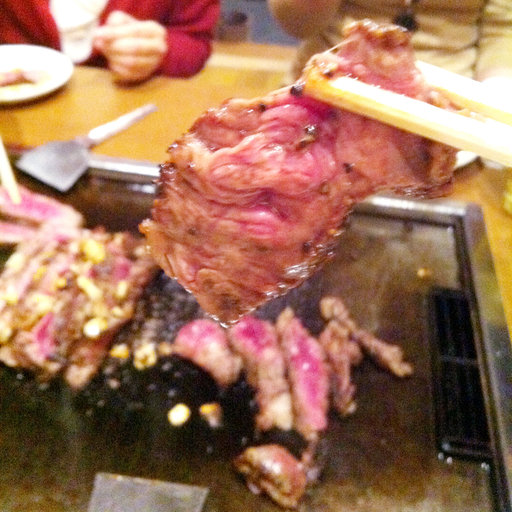

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

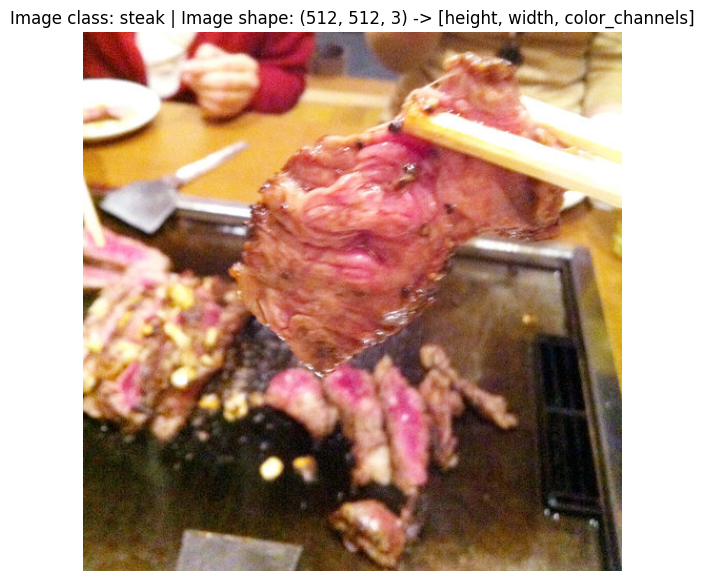

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming Data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

### 3.1 Transform data

In [10]:
# Write a transform for a image
data_transform = transforms.Compose(
    [
        # Resize images
        transforms.Resize(size = (64, 64)),

        # Flip the images
        transforms.RandomHorizontalFlip(p=0.5),

        # Turn into tensor
        transforms.ToTensor()
    ]
)

data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

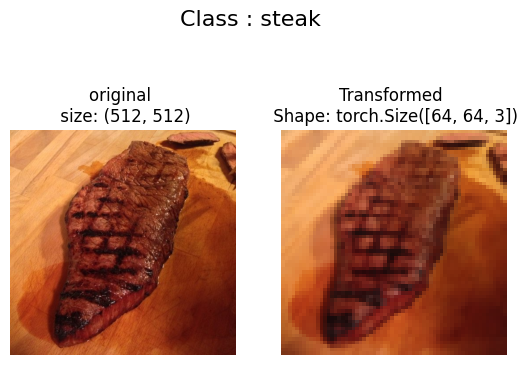

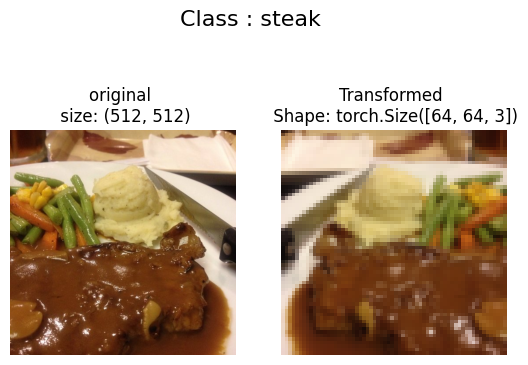

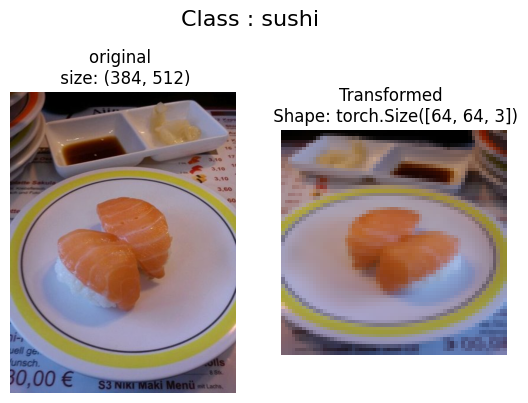

In [11]:
def plot_transformed_images(image_paths, transform, n = 3, seed=42):
  """ Selects random images from a path of images, trnasforms them and plots them"""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original \n size: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed = 42)

## 4.  Option 1 : Loading image data using ImageFolder

In [12]:
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform = data_transform, # For data
                                  target_transform=None # For label
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                                 transform= data_transform
                                 )

train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the length of datasets
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[199][0], train_data[199][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7373, 0.5412, 0.5255,  ..., 0.2275, 0.3569, 0.3765],
         [0.5373, 0.4784, 0.4314,  ..., 0.2392, 0.3843, 0.4510],
         [0.4431, 0.3647, 0.3059,  ..., 0.3098, 0.4196, 0.4784],
         ...,
         [0.3490, 0.3294, 0.3098,  ..., 0.8824, 0.8431, 0.8078],
         [0.4314, 0.4157, 0.3961,  ..., 0.8784, 0.8353, 0.7922],
         [0.5137, 0.4941, 0.4784,  ..., 0.8784, 0.8353, 0.7765]],

        [[0.4549, 0.3725, 0.4784,  ..., 0.1529, 0.2392, 0.2510],
         [0.3765, 0.4039, 0.4078,  ..., 0.1686, 0.2706, 0.3216],
         [0.3608, 0.3255, 0.2588,  ..., 0.2392, 0.3059, 0.3451],
         ...,
         [0.3490, 0.3216, 0.2941,  ..., 0.8824, 0.8431, 0.8039],
         [0.4431, 0.4157, 0.3922,  ..., 0.8863, 0.8392, 0.7922],
         [0.5255, 0.5098, 0.4863,  ..., 0.8824, 0.8314, 0.7686]],

        [[0.2118, 0.2667, 0.4980,  ..., 0.1255, 0.1961, 0.1922],
         [0.2706, 0.3922, 0.4471,  ..., 0.1294, 0.2078, 0.2471],
         [0.3608, 0.3490, 0.2667,  ..., 0.19

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


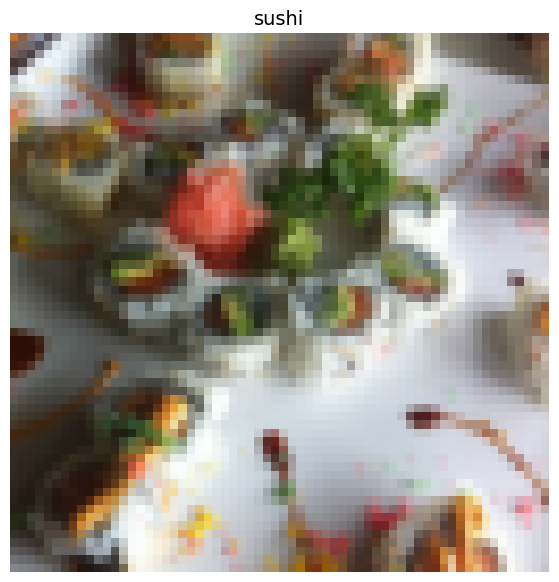

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into DataLoader's

In [18]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset= train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f11a2d8ba00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f11a2d8bb20>)

In [19]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [20]:
img, label = next(iter(train_dataloader))

# Batch Size will no be 1
print(f"Image Shape: {img.shape} --> [Batch_size, Channel, Height, Width]")
print(f"Label : {label.shape}")


Image Shape: torch.Size([1, 3, 64, 64]) --> [Batch_size, Channel, Height, Width]
Label : torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.Dataset.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})


### 5.1 Creating a helper function to get class names

In [26]:
# Setup path for target diectory
target_directory = train_dir

print(f"Target Dir : {target_directory}" )

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir (target_directory ))])
class_names_found

Target Dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())


    # 2. Raise an error if class names could not be found
    if not classes:
      raise FileNotFoundError(f"Could not find any classes in {directory}... Please check file structure ")

    # 3. Creare a dictionary of index labels
    class_to_idx = {class_name:i for i , class_name in enumerate(classes)}
    return classes, class_to_idx

In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})